<a href="https://colab.research.google.com/github/salu133445/ismir2019tutorial/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating MNIST Digit with GANs

## Prerequisites

### Install dependencies

In [1]:
!pip install -q torch torchvision matplotlib tqdm livelossplot

### Import libraries

In [2]:
from IPython.display import clear_output
from ipywidgets import interact, IntSlider

import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import tqdm
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

## Settings

In [3]:
# Data
feature_dim = 28 * 28

# Training
batch_size = 64
latent_dim = 128
n_steps = 20000

# Sampling
sample_interval = 100
n_cols = 15
n_rows = 2
n_samples = 30
assert n_samples == n_cols * n_rows, (
    "Number of samples and number of images per column/row do not match.")

## Training data loader function

In [4]:
def get_data_loader():
    """Download the MNIST dataset and create a data loader."""
    # MNIST training set
    mnist_train = torchvision.datasets.MNIST(
        root="./dataset",
        train=True,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )
    # MNIST test set
    mnist_test = torchvision.datasets.MNIST(
        root="./dataset",
        train=False,
        download=True,
        transform=torchvision.transforms.ToTensor()
    )
    # Use both traning and test sets
    dataset = torch.utils.data.ConcatDataset([mnist_train, mnist_test])
    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, drop_last=True, shuffle=True
    )
    return data_loader

## Utility functions

In [5]:
def images_to_vectors(images):
    """Convert images to vectors."""
    return images.view(images.size(0), 784)

def vectors_to_images(vectors):
    """Convert vectors to images."""
    return vectors.view(vectors.size(0), 1, 28, 28)

## Neural networks

In [6]:
class Generator(torch.nn.Module):
    """A multilayer perceptron (MLP) based generator. The generator takes as
    input a latent vector and outputs a fake sample."""
    def __init__(self):
        super().__init__()
        self.hidden0 = torch.nn.Linear(latent_dim, 128)
        self.hidden1 = torch.nn.Linear(128, 256)
        self.hidden2 = torch.nn.Linear(256, 512)
        self.out = torch.nn.Linear(512, feature_dim)

    def forward(self, x):
        x = torch.nn.functional.relu(self.hidden0(x))
        x = torch.nn.functional.relu(self.hidden1(x))
        x = torch.nn.functional.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [7]:
class Discriminator(torch.nn.Module):
    """A multilayer perceptron (MLP) based discriminator. The discriminator
    takes as input either a real sample (in the training data) or a fake sample
    (generated by the generator) and outputs a scalar indicating its authentity.
    """
    def __init__(self):
        super().__init__()
        self.hidden0 = torch.nn.Linear(feature_dim, 512)
        self.dropout0 = torch.nn.Dropout()
        self.hidden1 = torch.nn.Linear(512, 256)
        self.dropout1 = torch.nn.Dropout()
        self.hidden2 = torch.nn.Linear(256, 128)
        self.dropout2 = torch.nn.Dropout()
        self.out = torch.nn.Linear(128, 1)

    def forward(self, x):
        x = self.dropout0(torch.nn.functional.leaky_relu(self.hidden0(x)))
        x = self.dropout1(torch.nn.functional.leaky_relu(self.hidden1(x)))
        x = self.dropout2(torch.nn.functional.leaky_relu(self.hidden2(x)))
        x = self.out(x)
        return x

## Training function

In [8]:
def compute_gradient_penalty(discriminator, real_samples, fake_samples):
    """Compute the gradient penalty for regularization. Intuitively, the
    gradient penalty help stablize the magnitude of the gradients that the
    discriminator provides to the generator, and thus help stablize the training
    of the generator."""
    # Get random interpolations between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1).cuda()
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples))
    interpolates = interpolates.requires_grad_(True)
    # Get the discriminator output for the interpolations
    d_interpolates = discriminator(interpolates)
    # Get gradients w.r.t. the interpolations
    fake = torch.ones(real_samples.shape[0], 1).cuda()
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]
    # Compute gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [9]:
def train_one_step(d_optimizer, g_optimizer, real_samples):
    """Train the networks for one step."""
    # Sample from the lantent distribution
    latent = torch.randn(batch_size, latent_dim)

    # Transfer data to GPU
    if torch.cuda.is_available():
        real_samples = real_samples.cuda()
        latent = latent.cuda()
    
    # === Train the discriminator ===
    # Reset cached gradients to zero
    d_optimizer.zero_grad()
    # Get discriminator outputs for the real samples
    prediction_real = discriminator(real_samples)
    # Compute the loss function
    d_loss_real = torch.mean(torch.nn.functional.relu(1. - prediction_real))
    # Backpropagate the gradients
    d_loss_real.backward()
    
    # Generate fake samples with the generator
    fake_samples = generator(latent)
    # Get discriminator outputs for the fake samples
    prediction_fake_d = discriminator(fake_samples.detach())
    # Compute the loss function
    d_loss_fake = torch.mean(torch.nn.functional.relu(1. + prediction_fake_d))
    # Backpropagate the gradients
    d_loss_fake.backward()

    # Compute gradient penalty
    gradient_penalty = 10.0 * compute_gradient_penalty(
        discriminator, real_samples.data, fake_samples.data)
    # Backpropagate the gradients
    gradient_penalty.backward()

    # Update the weights
    d_optimizer.step()
    
    # === Train the generator ===
    # Reset cached gradients to zero
    g_optimizer.zero_grad()
    # Get discriminator outputs for the fake samples
    prediction_fake_g = discriminator(fake_samples)
    # Compute the loss function
    g_loss = -torch.mean(prediction_fake_g)
    # Backpropagate the gradients
    g_loss.backward()
    # Update the weights
    g_optimizer.step()

    return d_loss_real + d_loss_fake, g_loss

## Training preparation

In [10]:
# Create data loader
data_loader = get_data_loader()

# Create neural networks
discriminator = Discriminator()
generator = Generator()
n_params_g = sum(p.numel() for p in generator.parameters() if p.requires_grad)
n_params_d = sum(p.numel() for p in discriminator.parameters() if p.requires_grad)
print(f"Number of parameters in G: {n_params_g}")
print(f"Number of parameters in D: {n_params_d}")

# Create optimizers
d_optimizer = torch.optim.Adam(
    discriminator.parameters(), lr=0.001,  betas=(0.0, 0.9)
)
g_optimizer = torch.optim.Adam(
    generator.parameters(), lr=0.001, betas=(0.0, 0.9)
)

# Prepare the inputs for the sampler, which wil run during the training
sample_latent = torch.randn(n_samples, latent_dim)

# Transfer the neural nets and samples to GPU
if torch.cuda.is_available():
    discriminator = discriminator.cuda()
    generator = generator.cuda()
    sample_latent = sample_latent.cuda()

# Create an empty dictionary to sotre history samples
history_samples = {}

# Create a LiveLoss logger instance for monitoring
liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6,2))])

# Initialize step
step = 0

Number of parameters in G: 583312
Number of parameters in D: 566273


## Training iterations

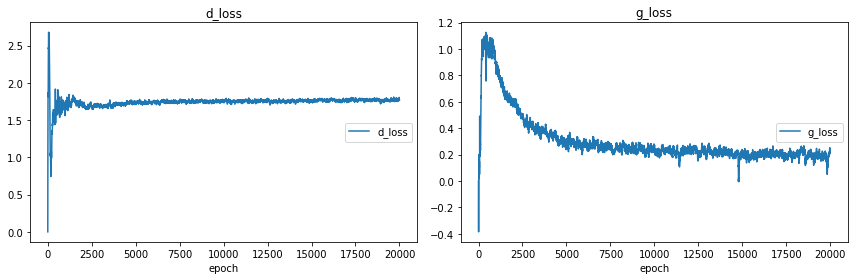

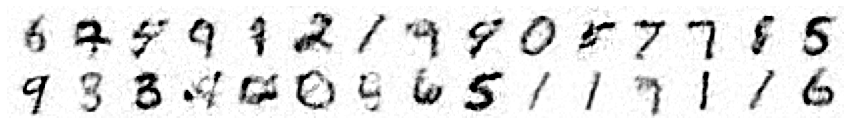

(d_loss= 1.691166, g_loss=-0.071677): 20001it [08:20, 30.73it/s]                

In [11]:
# Create a progress bar instance for monitoring
if step < n_steps + 1:
    progress_bar = tqdm(total=n_steps, initial=step, ncols=80, mininterval=1)
else:
    print(colored('[Warnings]', 'red'), 'Current step exceeds total step.')

# Start iterations
while step < n_steps + 1:
    # Iterate over the dataset
    for real_batch, _ in data_loader:
        # Convert input images into vetors
        real_samples = images_to_vectors(real_batch)

        # Train the neural networks
        d_loss, g_loss = train_one_step(d_optimizer, g_optimizer, real_samples)

        # Record smoothened loss values to LiveLoss logger
        if step > 0:
            running_d_loss = 0.05 * d_loss + 0.95 * running_d_loss
            running_g_loss = 0.05 * g_loss + 0.95 * running_g_loss
        else:
            running_d_loss, running_g_loss = 0.0, 0.0
        liveloss.update({'d_loss': running_d_loss, 'g_loss': running_g_loss})

        # Update losses to progress bar
        progress_bar.set_description_str(
            f"(d_loss={d_loss: 8.6f}, g_loss={g_loss: 8.6f})"
        )
        
        if step % sample_interval == 0:
            # Get generated samples
            samples = vectors_to_images(generator(sample_latent))
            samples = samples.cpu().detach().numpy() \
                             .reshape(n_rows, n_cols, 28, 28) \
                             .transpose((0, 2, 1, 3)) \
                             .reshape(n_rows * 28, n_cols * 28)
            history_samples[step] = samples

            # Display loss curves
            clear_output(True)
            if step > 0:
                liveloss.send()
            
            # Display generated samples
            plt.figure(figsize=(15, 3))
            plt.imshow(samples, cmap='Greys', vmin=0, vmax=1)
            plt.axis('off')
            plt.show()
            
        step += 1
        progress_bar.update(1)
        if step >= n_steps:
            break

Step=0


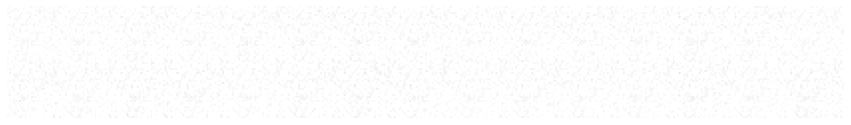

Step=100


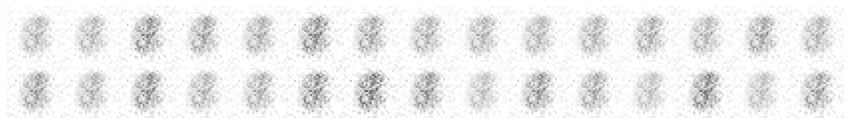

Step=1000


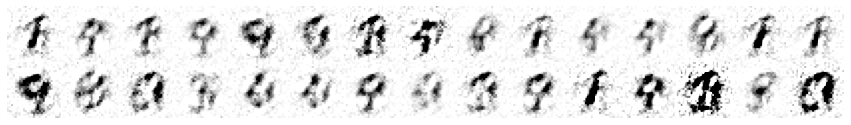

Step=10000


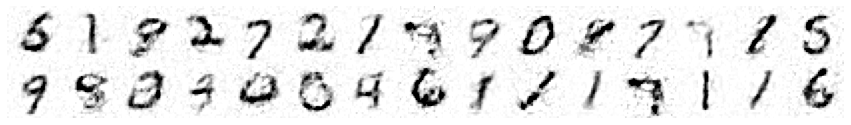

Step=20000


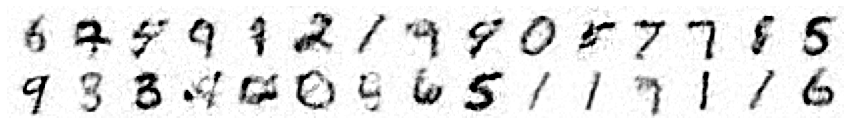

In [12]:
# Show history
steps = [0, sample_interval, 10 * sample_interval, 100 * sample_interval, n_steps]
for step in steps:
    print(f"Step={step}")
    plt.figure(figsize=(15, 3))
    plt.imshow(history_samples[step], cmap='Greys', vmin=0, vmax=1)
    plt.axis('off')
    plt.show()